<a href="https://colab.research.google.com/github/boothmanrylan/historicalFiresQC/blob/main/historicalFiresQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone Repo and Load Modules

In [1]:
import tensorflow as tf
import os
from google.colab import drive
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
drive.mount('/content/drive/')
%cd /content/drive/My\ Drive/historicalFiresQC

# if the directory doesn't exist clone it from github
! if [ ! -d ./historicalFiresQC/ ]; then git clone https://github.com/boothmanrylan/historicalFiresQC.git; fi


%cd ./historicalFiresQC/
! git pull
! git checkout stackedImages
%cd ../

! pip install q -r ./historicalFiresQC/requirements.txt

# import modules from historicalFiresQC
from historicalFiresQC import model as Model
from historicalFiresQC import data as Data
from historicalFiresQC import assessment as Assessment
from historicalFiresQC import visualize as Visualize

Mounted at /content/drive/
/content/drive/My Drive/historicalFiresQC
/content/drive/My Drive/historicalFiresQC/historicalFiresQC
Already up to date.
Already on 'stackedImages'
Your branch is up to date with 'origin/stackedImages'.
/content/drive/My Drive/historicalFiresQC
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-hofmxdev
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-hofmxdev
  Created wheel for tensorflow-examples: filename=tensorflow_examples-9c795bcd8520dc726c87cd699e714f1fbc0226dd_-cp36-none-any.whl size=157167 sha256=f0c6a5ba1fe99cd24e7cf67dcc5ca3df5b35fc71f1bd44c09d76bf3e651df113
  Stored in directory: /tmp/pip-ephem-wheel-cache-cn8_a0a0/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


# Reload Modules

This is only necessary to run if changes have been made to the historicalFiresQC modules since you started using the colab notebook. It will pull the changes and reload the modules, allowing the changes to be incorporated without having to restart the runtime. 

In [28]:
%cd ./historicalFiresQC
! git pull
# ! git checkout .
%cd ../

from importlib import reload

Model = reload(Model)
Data = reload(Data)
Assessment = reload(Assessment)
Visualize = reload(Visualize)

/content/drive/My Drive/historicalFiresQC/historicalFiresQC
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/boothmanrylan/historicalFiresQC
   1baf59b..f54598f  stackedImages -> origin/stackedImages
Updating 1baf59b..f54598f
Fast-forward
 assessment.py | 29 +++++++++++++++++++----------
 1 file changed, 19 insertions(+), 10 deletions(-)
/content/drive/My Drive/historicalFiresQC


# Global Variables

In [2]:
PATH = '/content/drive/My Drive/historicalFiresQC/'
DATAPATH = PATH + 'Data/Annotations/'
MODELPATH = PATH + 'Models/'
SHAPE = (128, 128)
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 100
STEPS_PER_EPOCH = 100

# If true, relative abundance of each class will be considered when calculating loss
# helps handle class imbalance
USE_CLASS_WEIGHTS = False

# ideally class weights would be determined by counting the number of occurances
# of each class in the dataset, but this is too time consuming for us
CLASS_WEIGHTS = [
    0.1, # None
    10., # Clouds
    10., # Water
    0.1, # Land
    10., # burn
]

if not USE_CLASS_WEIGHTS:
    CLASS_WEIGHTS = None

# setting this to true will load the model/weights from MODELPATH
LOADMODEL = True

# setting this to false will skip the model training step, therefore
# only set to false if LOADMODEL is true
TRAINMODEL = False

# if true, the model weights will be saved at MODELPATH, overwrittng any
# previous checkpoints that are there
SAVEMODEL = True

# dataset options
train_pattern = DATAPATH + 'train*.tfrecord.gz'
val_pattern = DATAPATH + 'val*.tfrecord.gz'
test_pattern = DATAPATH + 'test*.tfrecord.gz'
clean_annotation = True
noisy_annotation = (not clean_annotation)
combined_burnt = True
split_burnt = (not combined_burnt)
get_ref_points = False
get_merged_ref_points = False
get_burn_age = False
get_merged_burn_age = False
stack_image = False
include_date_difference = stack_image

# ensure we have the right number of classes set
if split_burnt: # include second burn class
    CLASSES = 6
    CLASS_WEIGHTS.append(CLASS_WEIGHTS[-1])
else:
    CLASSES = 5

# ensure we have the right number of channels set
if stack_image:
    if include_date_difference:
        CHANNELS = 9
    else:
        CHANNELS = 8
else:
    CHANNELS = 4

# ensure we are using the right model name
if USE_CLASS_WEIGHTS:
    MODELPATH += 'WeightedLoss'
if stack_image:
    MODELPATH += 'StackedImages'
else:
    if clean_annotation:
        MODELPATH += 'CleanAnnotations'
    else:
        MODELPATH += 'NoisyAnnotations'
if split_burnt:
    MODELPATH += 'SplitBurntClasses/'
else:
    MODELPATH += 'CombinedBurntClasses/'

# Load Data

In [3]:
print('Getting Training Data...')
train_dataset = Data.get_dataset(
    train_pattern, SHAPE, batch_size=BATCH_SIZE, filters=Data.filter_no_burnt,
    shuffle=True, repeat=True, prefetch=True, cache=True,
    clean_annotation=clean_annotation, noisy_annotation=noisy_annotation,
    combined_burnt=combined_burnt, split_burnt=split_burnt,
    get_ref_points=get_ref_points, get_merged_ref_points=get_merged_ref_points,
    get_burn_age=get_burn_age, get_merged_burn_age=get_merged_burn_age,
    get_images=True, stack_image=stack_image,
    include_date_difference=include_date_difference
)
print('Done Getting Training Data.\n')

print('Getting Validation Data...')
val_dataset = Data.get_dataset(
    val_pattern, SHAPE, batch_size=BATCH_SIZE, filters=None,
    shuffle=False, repeat=False, prefetch=True, clean_annotation=clean_annotation,
    noisy_annotation=noisy_annotation, combined_burnt=combined_burnt,
    split_burnt=split_burnt, get_ref_points=get_ref_points,
    get_merged_ref_points=get_merged_ref_points, get_burn_age=get_burn_age,
    get_merged_burn_age=get_merged_burn_age, get_images=True,
    stack_image=stack_image, include_date_difference=include_date_difference
)
print('Done Getting Validation Data.\n')

print('Getting Test Data...')
test_dataset = Data.get_dataset(
    test_pattern, SHAPE, batch_size=1, filters=None,
    shuffle=False, repeat=False, prefetch=True, clean_annotation=clean_annotation,
    noisy_annotation=noisy_annotation, combined_burnt=combined_burnt,
    split_burnt=split_burnt, get_ref_points=get_ref_points,
    get_merged_ref_points=get_merged_ref_points, get_burn_age=get_burn_age,
    get_merged_burn_age=get_merged_burn_age, stack_image=stack_image,
    include_date_difference=include_date_difference
)
print('Done Getting Test Data.\n')


Getting Training Data...
Done Getting Training Data.

Getting Validation Data...
Done Getting Validation Data.

Getting Test Data...
Done Getting Test Data.



# Build Model

In [3]:
print('Building Model...')
model = Model.build_unet_model(input_shape=(*SHAPE, CHANNELS), classes=CLASSES)
if LOADMODEL:
    if os.path.exists(MODELPATH + 'saved_model.pb'): # load the entire model
        model = tf.keras.models.load_model(MODELPATH)
    else: # just load the model weights
        if TRAINMODEL:
            model.load_weights(MODELPATH)
        else: # squash unresolved object warnings when only using the model for inference
            model.load_weights(MODELPATH).expect_partial()
print('Done Building Model.\n')

if TRAINMODEL:
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=MODELPATH, save_weights_only=True,
        save_freq=STEPS_PER_EPOCH
    )
    if SAVEMODEL:
        callbacks = [checkpoint]
    else:
        callbacks = None

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    if USE_CLASS_WEIGHTS:
        loss = Model.weighted_loss(
            tf.keras.losses.sparse_categorical_crossentropy,
            CLASS_WEIGHTS,
            from_logits=True
        )
    else:
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics=['accuracy']
    
    print('Compiling Model...')
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print('Done Compiling Model.\n')
    
    print('Training Model...')
    model.fit(
        train_dataset, epochs=EPOCHS, verbose=1,
        steps_per_epoch=STEPS_PER_EPOCH, callbacks=callbacks,
    )
    print('Done Traing Model.\n')

Building Model...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/applications/imagenet_utils.py:333: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  str(input_shape[-1]) + ' input channels.')


Done Building Model.



<!-- # Model Assessment -->

/content/drive/My Drive/historicalFiresQC/historicalFiresQC/visualize.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, num_figs, figsize=(15, 30))


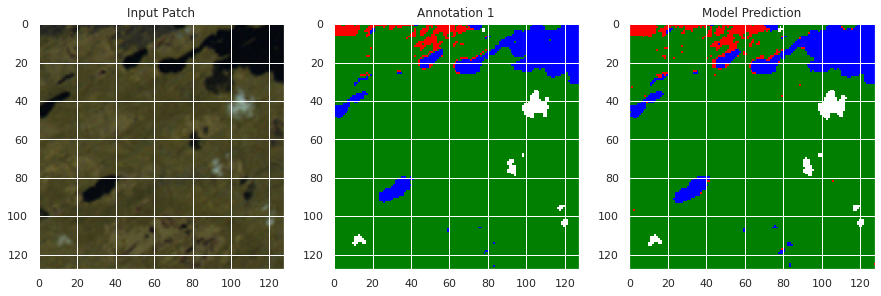

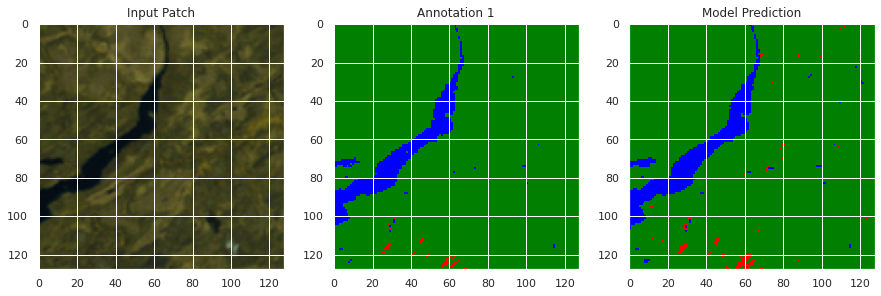

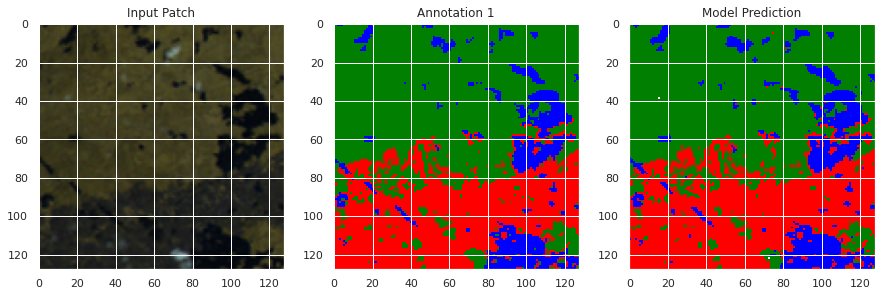

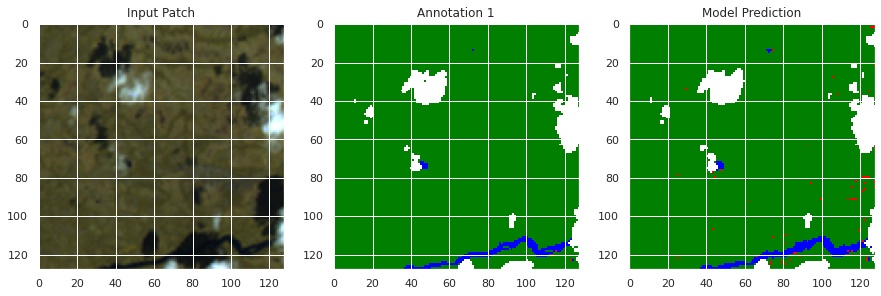

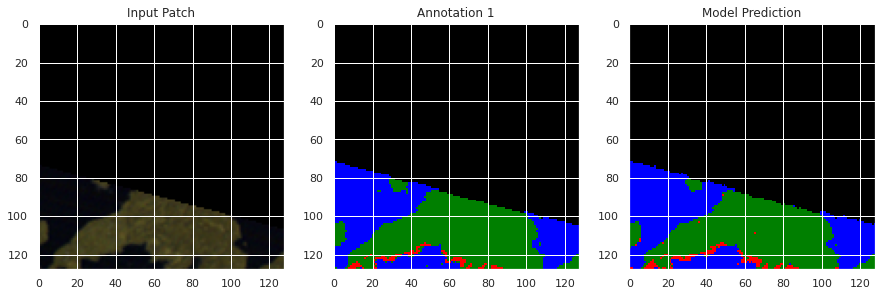

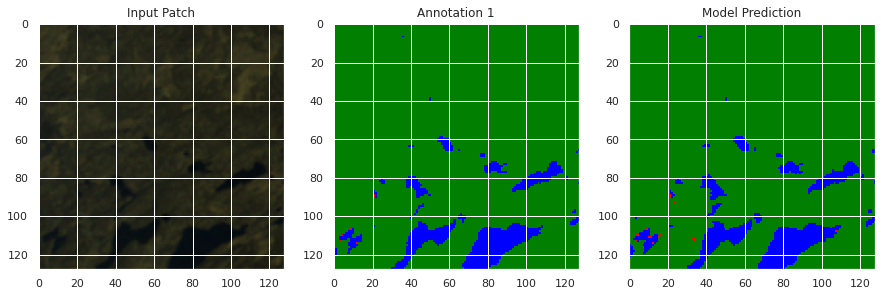

Error in callback <function flush_figures at 0x7f48c4cc3f28> (for post_execute):


KeyboardInterrupt: ignored

In [23]:
Visualize.visualize(train_dataset, model, num=100, stacked_image=False)

# Assessment

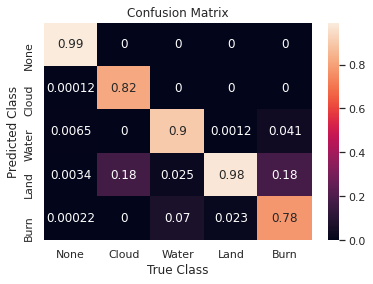

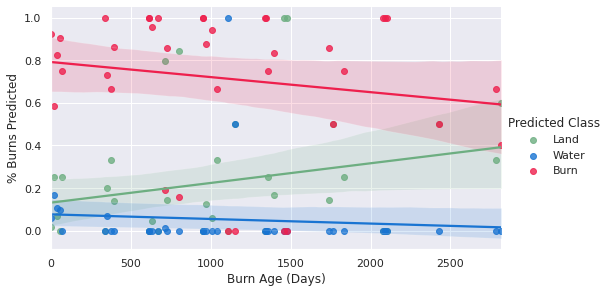

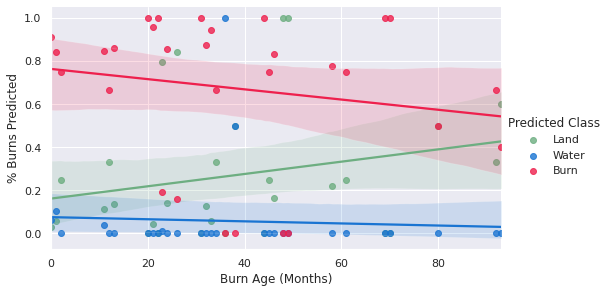

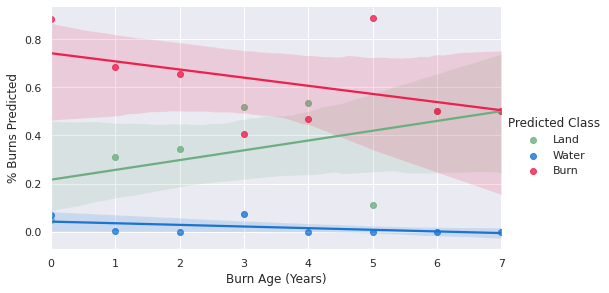

In [5]:
def burn_age_plot(model, dataset, class_labels, scale):
    try:
        assert scale in ['days', 'months', 'years']
    except AssertionError as E:
        raise ValueError(
            f'scale must be one of days, months, or years got {scale}'
        ) from E
    num_classes = len(class_labels)
    input = Assessment.dated_burn_accuracy(model, dataset, num_classes, scale)

    count_df = pd.DataFrame.from_dict(input)
    count_df.index = class_labels
    percentage_df = count_df / count_df.sum()
    percentage_df = percentage_df.melt(ignore_index=False).reset_index()
    count_df = count_df.melt(ignore_index=False).reset_index()

    x_label = f'Burn Age ({scale.capitalize()}'
    hue_label = 'Predicted Class'
    y_label = 'Percentage'
    size_label = 'Count'
    
    percentage_df.columns = [hue_label, x_label, y_label]
    count_df.columns = [hue_label, x_label, size_label]

    count_df[y_label] = percentage_df[y_label]

    palette = sns.crayon_palette(
        ['Forest Green', 'Navy Blue', 'Red']
    )
    hue_order = ['Land', 'Water', 'Burn']

    count_df = count_df[count_df[hue_label].isin(hue_order)]
    
    sns.set_style()
    f, ax = plt.subplots(figsize=(14, 4))
    sns.scatterplot(data=count_df, x=x_label, y=y_label, hue=hue_label,
                    size=size_label, palette=palette, hue_order=hue_order,
                    ax=ax)

def assessment(model, datasetpattern, stack_image, merged_refs, class_labels):
    ca = False
    split = False
    cart = False
    images = True
    reference_dataset = Data.get_dataset(
        datasetpattern, SHAPE, shuffle=False, repeat=False,
        clean_annotation=ca, noisy_annotation=False, combined_burnt=(not split),
        split_burnt=split, get_ref_points=(not merged_refs),
        get_merged_ref_points=merged_refs, get_burn_age=False,
        get_merged_burn_age=False, stack_image=stack_image, get_images=images,
        get_CART_classification=cart, include_date_difference=stack_image,
        get_stacked_CART_classification=(stack_image and cart)
    )

    burn_age_dataset = Data.get_dataset(
        datasetpattern, SHAPE, shuffle=False, repeat=False,
        clean_annotation=ca, noisy_annotation=False, combined_burnt=(not split),
        split_burnt=split, get_ref_points=(not merged_refs),
        get_merged_ref_points=merged_refs, get_burn_age=(not merged_refs),
        get_merged_burn_age=merged_refs, stack_image=stack_image,
        get_images=images, get_CART_classification=cart,
        include_date_difference=stack_image,
        
        get_stacked_CART_classification=(stack_image and cart)
    )

    num_classes = len(class_labels)

    confusion_matrix = Assessment.reference_accuracy(
        model, reference_dataset, num_classes
    )

    norm_confusion_matrix = Assessment.normalize_confusion_matrix(
        confusion_matrix
    )

    Assessment.plot_confusion_matrix(
        norm_confusion_matrix, class_labels
    )
    
    Assessment.plot_burn_accuracy_by_burn_age(
        model, burn_age_dataset, class_labels, 'days'
    )

    Assessment.plot_burn_accuracy_by_burn_age(
        model, burn_age_dataset, class_labels, 'months'
    )

    Assessment.plot_burn_accuracy_by_burn_age(
        model, burn_age_dataset, class_labels, 'years'
    )

    # burn_age_plot(model, burn_age_dataset, class_labels, 'years')
sns.set_style()
class_labels = ['None', 'Cloud', 'Water', 'Land', 'Burn']
assessment(model, [val_pattern, test_pattern], False, False, class_labels)